In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random
import re

/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

# Comparison on multiple datasets

In [4]:
import openml
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

In [5]:
import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

In [6]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [7]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [8]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [9]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    #y_test_appended = np.concatenate([y_test,[1]])
    y_test_appended = clf.predict(X_test_appended)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [10]:
shap.initjs()

In [11]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [12]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [13]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

In [14]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            if len((set(v1)|set(v2))) == 0:
                jackard = 0
            else:
                jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

In [15]:
def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        accuracy =  accuracy_score(dataset['class'],np.ones(len(dataset))*float(prediction))
        precision =  precision_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        recall =  recall_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        f1 =  f1_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        return 1,accuracy, precision, recall, f1
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f' and {i}{op}'.join(v))
    print(' and '.join(query))
    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

In [16]:
def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            if len(set(rule_1.keys())|set(rule_2.keys())) == 0:
                feature_jackart[i,ii] = 0
            else:
                feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired



In [17]:
def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Main comparison loop

## Benchmark, model agnostic

In [18]:
def lore_fit(clf,train, explain_instance,categorical_indicator):
    myds = prepare_ds(train,class_name='class',discrete=categorical_indicator)
    instance2explain = explain_instance.ravel()
    X_explain = np.concatenate(([instance2explain], myds['X']))
    
    Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,ng_function=genetic_neighborhood, 
                                  discrete_use_probabilities=True, continuous_function_estimation=False)
    
    datalore = Data.parse_dataframe(Zdf)
    uid3 = UId3(max_depth=4,node_size_limit=2)
    uid3.fit(datalore,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=1)
    return uid3

In [19]:
def explan_fit(clf,train, explain_instance,features, categorical_indicator):
    myds = prepare_ds(train,class_name='class',discrete=categorical_indicator)
    #myds = prepare_ds(dfneigh_tr,discrete=categorical_indicator)
    X, y = myds['X'], myds['y']
    instance2explain = explain_instance.ravel()
    
    # EXPLAN hyper-parameters
    N_samples = 3000#n_neighbors
    tau = 250#int(n_neighbors)/len(np.unique(df[target])
    
    
    dense_samples = DataGeneration(instance2explain, clf, myds, 3000)
    # Representative data selection step
    representative_samples = DataSelection(instance2explain, clf, dense_samples, 250)
    # Data balancing step
    neighborhood_data = DataBalancing(clf, representative_samples, myds)
    
    Ndf = pd.DataFrame(neighborhood_data, columns=features)
    Ndf['class'] = clf.predict(Ndf[features])
    
    data = Data.parse_dataframe(Ndf)
    uid3 = UId3(max_depth=4,node_size_limit=2)
    uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=1)
    return uid3

In [20]:
def predict_lux(model,X,y=None):
        if isinstance(X, pd.DataFrame):
            pass
        elif isinstance(X,np.ndarray):
            X = pd.DataFrame(X,columns=model.attributes_names)
        else:
            raise ValueError("Only 2D arrrays are allowed as an input")
            
        if y is None:
            y = pd.Series(np.arange(X.shape[0]),name='target_unused',index=X.index) # This is not used, but Data resered last 
                
        X=pd.concat((X,y),axis=1)
        XData = Data.parse_dataframe(X,'lux')
        return [int(f.get_name()) for f in model.predict(XData.get_instances())]

In [21]:
def generate_lore_dataset(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [22]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

def show_shap_values(instance_to_explain, X_test, wclf, feature_columns, num_samples=1000, sorted=True):
    """
    Function to show SHAP values for a given instance using a classifier.

    Parameters:
    - instance_to_explain: The instance to explain (single row).
    - X_test: The test dataset (DataFrame) containing the features.
    - wclf: The trained classifier (e.g., a wrapped classifier for SHAP).
    - feature_columns: List of feature names.
    - num_samples: Number of samples to draw from X_test for SHAP calculation (default is 1000).
    - sorted: If True, sort the features by SHAP value in ascending order before plotting.
    """
    # Combine the instance to explain with a sample of the test set
    X_shap = pd.concat((pd.DataFrame(instance_to_explain, columns=feature_columns), 
                        X_test[feature_columns].sample(num_samples)))

    try:
        explainer = shap.Explainer(wclf, X_shap,seed=42)
        if hasattr(explainer, "shap_values"):
            shap_values = explainer.shap_values(X_shap, check_additivity=False)
        else:
            shap_values = explainer(X_shap).values
            shap_values = [sv for sv in np.moveaxis(shap_values, 2, 0)]
        if hasattr(explainer, "expected_value"):
            expected_values = explainer.expected_value
        else:
            expected_values = [np.mean(v) for v in shap_values]
    except TypeError:
        explainer = shap.Explainer(wclf.predict_proba, X_shap,seed=42)
        shap_values = explainer(X_shap).values
        shap_values = [sv for sv in np.moveaxis(shap_values, 2, 0)]
        expected_values = [np.mean(v) for v in shap_values]

    # Handle single list case
    if type(shap_values) is not list:
        shap_values = [-shap_values, shap_values]
        expected_values = [np.mean(v) for v in shap_values]

    # Calculate mean absolute SHAP values
    mean_shap_values = np.abs(shap_values).mean(0)[0]
    
    # Sort the SHAP values and feature names if sorted=True
    if sorted:
        sorted_indices = np.argsort(mean_shap_values)
        mean_shap_values = mean_shap_values[sorted_indices]
        feature_columns = np.array(feature_columns)[sorted_indices]

    # Plot SHAP values
    plt.figure(figsize=(12, 9))
    plt.barh(feature_columns, mean_shap_values)
    plt.xlabel("Mean Absolute SHAP Value")
    plt.title("Feature Importance (SHAP Values)")
    plt.show()


In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# load the data into Pandas DataFrame
df = pd.read_csv('./data/tcm5_dataset_1.csv').dropna()
# make lists with columns related to features and anomalies
anomaly_columns = [c for c in df.columns if 'Anomaly' in c]
feature_columns = [c for c in df.columns if c not in anomaly_columns]
# divide the data into X (features) and Y (labels)
X = df.loc[:, feature_columns]
Y = df.loc[:, anomaly_columns]
# create array which tells us if any type of anomaly is present in the observation
y = (Y.sum(axis=1) != 0).values

# divide dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# define, train and evaluate ML model
iforest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iforest.fit(X_train)
y_test_pred = iforest.predict(X_test) == -1
f1 = f1_score(y_test, y_test_pred)
f1

0.6139954853273137

In [24]:
class NoProbaWrapper():
    def __init__(self,clf,n_classes):
        self.clf = clf
        self.n_classes= n_classes
    def predict_proba(self,X):
        hot = (self.clf.predict(X)==-1).astype(int)
        y_train_sample = np.zeros((len(hot),self.n_classes))
        for i in range(0,len(y_train_sample)):
            y_train_sample[i,hot[i]] = 1
        return y_train_sample

    def predict(self,X):
        return (self.clf.predict(X)==-1).astype(int)

wclf = NoProbaWrapper(iforest,2)
wclf.predict_proba(X)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [25]:
#correct anomaly
instance_to_explain_cr = X_test[(wclf.predict(X_test)==1) & (y_test==1)].iloc[0].values.reshape(1,-1)

#incorrect_anomaly
instance_to_explain_icr = X_test[(wclf.predict(X_test)==1) & (y_test==0)].iloc[0].values.reshape(1,-1)




luxc = LUX(predict_proba = wclf.predict_proba, classifier=wclf,neighborhood_size=0.01,max_depth=4,  min_samples=2,
                      oversampling_strategy='importance',
                      node_size_limit = 2, grow_confidence_threshold = 0,min_generate_samples=0.01)
SAMPLES=10

Permutation explainer: 102it [01:22,  1.08it/s]                         


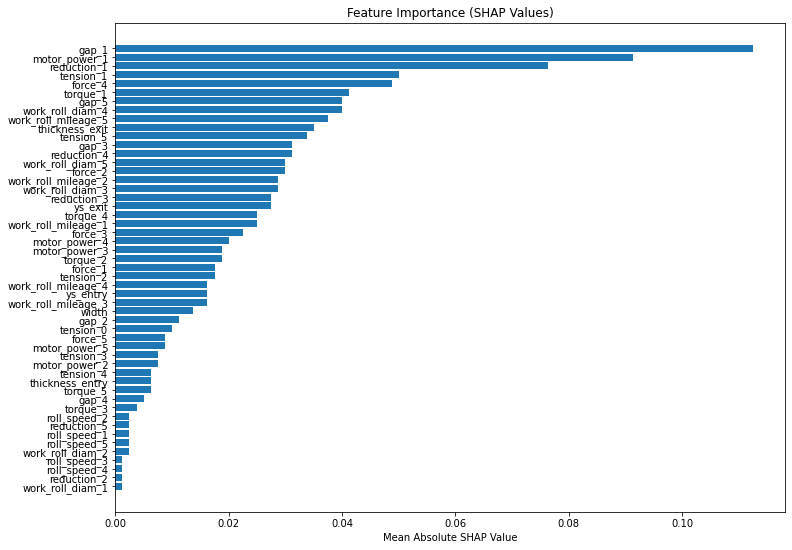

In [40]:
#show shap values for instance_to_explain_cr
show_shap_values(instance_to_explain=instance_to_explain_cr, X_test=X_test, wclf=wclf, feature_columns=feature_columns, num_samples=100)

In [27]:
luxc = LUX(predict_proba = wclf.predict_proba, classifier=wclf,neighborhood_size=0.01,max_depth=4,  min_samples=2,
                      oversampling_strategy='importance',
                      node_size_limit = 2, grow_confidence_threshold = 0,min_generate_samples=0.01)
lux_corrects = []
for i in range(SAMPLES):
    luxc.fit(X_train,wclf.predict(X_train), instance_to_explain_cr, X_importances = None, exclude_neighbourhood=False, use_parity=True,
            parity_strategy='global',inverse_sampling=True, class_names=None, discount_importance = False,
            uncertain_entropy_evaluator = UncertainEntropyEvaluator(),beta=1,representative='centroid',
            density_sampling=False, radius_sampling = False,oversampling=True,categorical=None,prune=True, oblique=True,  n_jobs=None)
    correct_justification = luxc.justify(instance_to_explain_cr)
    #cf = luxc.counterfactual(np.array(instance_to_explain_cr), X_train.sample(1000), counterfactual_representative='nearest', topn=1)[0]
    lux_corrects.append(correct_justification)
    print(correct_justification)

Permutation explainer: 170it [01:47,  1.44it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:03,  1.67it/s]                         
Permutation explainer: 134it [01:22,  1.43it/s]                         
Permutation explainer: 122it [01:33,  1.16it/s]                         
Permutation explainer: 290it [02:55,  1.56it/s]                         
Permutation explainer: 245it [02:04,  1.85it/s]                         
Permutation explainer: 46it [00:21,  1.26it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:08,  1.21it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:36,  1.48it/s]                         
Permutation explainer: 134it [01:39,  1.20it/s]                         
Permutation explainer: 122it [01:47,  1.02it/s]                         
Permutation explainer: 290it [02:34,  1.79it/s]                         
Permutation explainer: 245it [02:10,  1.76it/s]                         
Permutation explainer: 46it [00:22,  1.13it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:07,  1.24it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:49,  1.41it/s]                         
Permutation explainer: 134it [01:29,  1.35it/s]                         
Permutation explainer: 122it [01:48,  1.01it/s]                         
Permutation explainer: 290it [03:00,  1.53it/s]                         
Permutation explainer: 245it [01:51,  2.06it/s]                         
Permutation explainer: 46it [00:22,  1.01s/it]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:13,  1.18it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:36,  1.48it/s]                         
Permutation explainer: 134it [01:48,  1.14it/s]                         
Permutation explainer: 122it [01:55,  1.03s/it]                         
Permutation explainer: 290it [02:43,  1.67it/s]                         
Permutation explainer: 245it [02:09,  1.78it/s]                         
Permutation explainer: 46it [00:25,  1.09it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:04,  1.25it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:37,  1.48it/s]                         
Permutation explainer: 134it [01:45,  1.14it/s]                         
Permutation explainer: 122it [01:55,  1.05s/it]                         
Permutation explainer: 290it [02:40,  1.71it/s]                         
Permutation explainer: 245it [02:14,  1.72it/s]                         
Permutation explainer: 46it [00:21,  1.15it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:01,  1.29it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:40,  1.46it/s]                         
Permutation explainer: 134it [01:41,  1.18it/s]                         
Permutation explainer: 122it [01:55,  1.05s/it]                         
Permutation explainer: 290it [02:40,  1.71it/s]                         
Permutation explainer: 245it [02:07,  1.81it/s]                         
Permutation explainer: 46it [00:21,  1.15it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:01,  1.29it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:41,  1.45it/s]                         
Permutation explainer: 134it [01:30,  1.33it/s]                         
Permutation explainer: 122it [01:46,  1.02it/s]                         
Permutation explainer: 290it [02:59,  1.54it/s]                         
Permutation explainer: 245it [02:02,  1.87it/s]                         
Permutation explainer: 46it [00:21,  1.15it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:08,  1.22it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:36,  1.47it/s]                         
Permutation explainer: 134it [01:32,  1.30it/s]                         
Permutation explainer: 122it [01:43,  1.06it/s]                         
Permutation explainer: 290it [03:05,  1.48it/s]                         
Permutation explainer: 245it [02:00,  1.92it/s]                         
Permutation explainer: 46it [00:23,  1.17it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:22,  1.10it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:34,  1.49it/s]                         
Permutation explainer: 134it [01:36,  1.24it/s]                         
Permutation explainer: 122it [01:38,  1.10it/s]                         
Permutation explainer: 290it [03:05,  1.48it/s]                         
Permutation explainer: 245it [01:58,  1.94it/s]                         
Permutation explainer: 46it [00:20,  1.09it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


Permutation explainer: 170it [02:13,  1.17it/s]                         


Done 0.5857988165680473 upsampling
Done 0.9112426035502958 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 423it [04:42,  1.45it/s]                         
Permutation explainer: 134it [01:40,  1.20it/s]                         
Permutation explainer: 122it [01:42,  1.07it/s]                         
Permutation explainer: 290it [02:50,  1.61it/s]                         
Permutation explainer: 245it [02:17,  1.67it/s]                         
Permutation explainer: 46it [00:19,  1.18it/s]                        


['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n']


In [28]:
lux_corrects

[['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2 <13.095000267028809 THEN class = 1 # 0.9959016393442625\n'],
 ['IF gap_1 >=2.3558402061462402 AND work_roll_mileage_2

In [29]:
# import graphviz
# from graphviz import Source
# from IPython.display import SVG, Image

# #counterfactual
# i2edf = pd.DataFrame(instance_to_explain_cr,columns=X_train.columns)
# i2edf['class'] = wclf.predict(i2edf)

# cfdf = pd.DataFrame(cf['counterfactual']).T
# cfdf['class'] = wclf.predict(cfdf.values.reshape(1,-1))[0]

# Xtc = X_train.copy()
# Xtc['class'] = wclf.predict(X_train)
# luxc.uid3.tree.save_dot('./pix/industrial_tree-cf-visual.dot',fmt='.2f',visual=True, background_data=Xtc, instance2explain = i2edf,counterfactual=cfdf)
# gvz=graphviz.Source.from_file('./pix/industrial_tree-cf-visual.dot')
# !dot -Tpng ./pix/industrial_tree-cf-visual.dot > industrial_tree.png
# Image('industrial_tree.png')

In [30]:
# lux_incorrects = []
# for i in range(SAMPLES):
#     luxc.fit(X_train,wclf.predict(X_train), instance_to_explain_icr, X_importances = None, exclude_neighbourhood=False, use_parity=True,
#             parity_strategy='global',inverse_sampling=True, class_names=None, discount_importance = False,
#             uncertain_entropy_evaluator = UncertainEntropyEvaluator(),beta=1,representative='centroid',
#             density_sampling=False, radius_sampling = False,oversampling=True,categorical=None,prune=True, oblique=True,  n_jobs=None)
#     incorrect_justification = luxc.justify(instance_to_explain_icr)
#     lux_incorrects.append(incorrect_justification)
#     #print(incorrect_justification)

In [31]:
# lux_incorrects

In [32]:
# import graphviz
# from graphviz import Source
# from IPython.display import SVG, Image

# #counterfactual
# i2edf = pd.DataFrame(instance_to_explain_icr,columns=X_train.columns)
# i2edf['class'] = wclf.predict(i2edf)
# Xtc = X_train.copy()
# Xtc['class'] = wclf.predict(X_train)
# luxc.uid3.tree.save_dot('./pix/industrial_tree-cf-visual.dot',fmt='.2f',visual=True, background_data=Xtc, instance2explain = i2edf)
# gvz=graphviz.Source.from_file('./pix/industrial_tree-cf-visual.dot')
# !dot -Tpng ./pix/industrial_tree-cf-visual.dot > industrial_tree.png
# Image('industrial_tree.png')

In [29]:
Xtc = X_train.copy()
Xtc['class'] = wclf.predict(X_train)

In [33]:

explan_corrects = []
for i in range(SAMPLES): 
    features = [f for f in X_train.columns if f not in ['class']]
    u3 =explan_fit(wclf,Xtc, instance_to_explain_cr,features,[False]*len(features))
    lux = LUX(wclf.predict_proba)
    lux.uid3 = u3
    lux.attributes_names=features
    justification_dict_cr = lux.justify(instance_to_explain_cr)
    lux.justify(instance_to_explain_cr)
    explan_corrects.append(justification_dict_cr)

In [34]:
explan_corrects

[['IF force_1 <13706934.0 AND force_3 <7663640.0 AND force_2 <10359121.0 THEN class = 1 # 0.8474945533769063\n'],
 ['IF force_2 <10332740.0 AND force_3 <8484569.0 THEN class = 1 # 0.7529411764705882\n'],
 ['IF force_2 <9489658.5 AND force_3 <8368194.0 AND force_1 <13209804.5 THEN class = 1 # 0.8320610687022901\n'],
 ['IF force_1 <13392458.5 AND force_3 <7552649.5 AND force_2 <10263149.5 THEN class = 1 # 0.8232758620689655\n'],
 ['IF force_2 <10493789.5 AND force_3 <8444457.0 AND force_5 <4895938.5 THEN class = 1 # 0.7658959537572254\n'],
 ['IF force_2 <9671644.0 AND force_3 <8455487.5 THEN class = 1 # 0.7398843930635838\n'],
 ['IF force_1 <13239552.0 AND force_3 <8594120.0 AND force_2 <10394691.5 THEN class = 1 # 0.8346007604562737\n'],
 ['IF force_3 <8268198.5 AND force_5 <4955977.0 AND force_2 <9447845.0 AND force_1 <12653200.0 THEN class = 1 # 0.7782705099778271\n'],
 ['IF force_2 <10389383.0 AND force_3 <8240916.0 AND ys_exit <592.365966796875 THEN class = 1 # 0.8308457711442786\n'

In [35]:
# explan_incorrects = []
# for i in range(SAMPLES): 
#     features = [f for f in X_train.columns if f not in ['class']]
#     u3 =explan_fit(wclf,Xtc, instance_to_explain_icr,features,[False]*len(features))
#     lux = LUX(wclf.predict_proba)
#     lux.uid3 = u3
#     lux.attributes_names=features
#     justification_dict_icr = lux.justify(instance_to_explain_icr)
#     lux.justify(instance_to_explain_icr)
#     explan_incorrects.append(justification_dict_icr)

In [36]:
lore_corrects = []
for i in range(SAMPLES):
    try:
        u3=lore_fit(wclf,Xtc, instance_to_explain_cr,[False]*len(features))
        lux = LUX(wclf.predict_proba)
        lux.uid3 = u3
        lux.attributes_names=features
        justification_dict_cr = lux.justify(instance_to_explain_cr)#, to_dict=True)[0][0]
        lux.justify(instance_to_explain_cr)
        lore_corrects.append(justification_dict_cr)
    except:
        pass

In [37]:
lore_corrects

[['IF work_roll_diam_4 >=570.5 AND work_roll_diam_3 <559.5 THEN class = 1 # 1.0\n'],
 ['IF torque_4 >=65664.5 THEN class = 1 # 0.9979838709677418\n'],
 ['IF torque_4 >=63764.0 AND work_roll_diam_5 <582.7134704589844 THEN class = 1 # 1.0\n'],
 ['IF thickness_entry == 4.0 THEN class = 1 # 1.0\n'],
 ['IF gap_1 >=1.6115000247955322 AND motor_power_3 <3805.71435546875 AND work_roll_diam_1 >=540.5 THEN class = 1 # 0.9960159362549801\n'],
 ['IF gap_2 >=0.840499997138977 THEN class = 1 # 0.9962962962962963\n'],
 ['IF width == 1233.0 THEN class = 1 # 0.9974811083123425\n'],
 ['IF thickness_entry == 4.0 AND motor_power_3 >=2767.372802734375 AND reduction_2 >=0.2044999971985817 THEN class = 1 # 0.9977628635346756\n']]

In [36]:
# lore_incorrects = []
# for i in range(SAMPLES): 
#     try:
#         u3=lore_fit(wclf,Xtc, instance_to_explain_icr,[False]*len(features))
#         lux = LUX(wclf.predict_proba)
#         lux.uid3 = u3
#         lux.attributes_names=features
#         justification_dict_icr = lux.justify(instance_to_explain_icr)#, to_dict=True)[0][0]
#         lux.justify(instance_to_explain_icr)
#         lore_incorrects.append(instance_to_explain_icr)
#     except:
#         pass


In [38]:
anchor_corrects=[]
for i in range(SAMPLES):
    try:
        features = [f for f in Xtc.columns if f not in ['class']]
        myds = prepare_ds(Xtc,class_name='class',discrete=[False]*len(features))
        instance2explain = instance_to_explain_cr.ravel()
        X_explain = np.concatenate(([instance2explain], myds['X']))
        anchor_explainer = fit_anchor(myds, Xtc[features], Xtc[features], Xtc['class'], Xtc['class'], X_explain)
        exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                    wclf.predict, threshold=0.8)

        rule_Anchor_full = anchor2arule(exp_Anchor)
        anchor_corrects.append(rule_Anchor_full)
    except:
       pass

In [49]:
def translate_rule(rule_dict):
    conditions = []
    for feature, constraint in rule_dict.items():
        if '<' in constraint and '>' in constraint:
            # Handle compound range
            conditions.append(constraint.replace(feature, f"{feature}"))
        else:
            # Simple inequality
            conditions.append(f"{feature} {constraint}")
    return "IF " + " AND ".join(conditions) + " THEN class 1"

# Apply to the rule
for i in range(len(anchor_corrects)):
    human_readable_rule = translate_rule(anchor_corrects[i])
    print(human_readable_rule)

IF tension_1 >274533.25 AND motor_power_1 <=2927.27 AND torque_4 >69737.25 AND torque_2 >92703.00 AND force_5 >3635474.25 AND roll_speed_1 <=5.61 AND reduction_3 >0.15 AND reduction_2 >0.23 AND torque_5 >55043.00 AND torque_1 <=128140.50 AND reduction_1 <=0.33 AND torque_3 >94818.50 AND force_1 <=15310972.75 AND force_2 >8609325.75 AND width <=1233.00 AND thickness_entry <=4.00 AND ys_entry <=583.00 AND thickness_exit 1.19 < thickness_exit <= 1.69 AND gap_1 >2.53 AND tension_4 >512781.50 AND tension_5 >115663.25 AND force_4 >4997474.00 AND ys_exit <=577.00 THEN class 1
IF tension_1 >274533.25 AND motor_power_1 <=2927.27 AND torque_4 >69737.25 AND reduction_4 >0.09 AND reduction_5 >0.05 AND torque_3 >94818.50 AND force_2 >8609325.75 AND roll_speed_1 <=5.61 AND width <=1233.00 AND roll_speed_5 <=11.73 AND torque_5 >55043.00 AND ys_entry <=583.00 AND roll_speed_4 <=11.10 AND force_5 >3635474.25 AND thickness_entry <=4.00 AND thickness_exit 1.19 < thickness_exit <= 1.69 AND roll_speed_2 <=